## preprocessing

After some deliberation, we need to perform the following preprocessing steps in service of visualizations:

1. Assign buildings to blocks. *done*
2. Assign blockfaces to blocks. *done*
3. Assign buildings to blockfaces. *manual*
4. Assign blockfaces to street segments.
5. Assign buildings to street frontages.

Assuming we grind through these we will be able to assign litter blame to individual address frontages and up.

In [1]:
import pandas as pd
import geopandas as gpd

buildings = gpd.read_file("../data/SF_Bldg_201610.gdb.zip").to_crs({"init": "epsg:4326"})
streets = gpd.read_file("../data/sf-street-centerlines.geojson")
blocks = gpd.read_file("../data/sf-census-blocks.geojson")

df = pd.read_excel("../data/one-month-data.xlsx")
from shapely.geometry import Point
trash = gpd.GeoDataFrame(df, geometry=df.apply(lambda srs: Point((srs['long'], srs['lat'])), axis='columns'))
del df

In [2]:
pd.set_option('max_columns', None)
buildings.head(3)

,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry
0,201006.0000001,1,SF4570025,16.3249,66.2671,178250,507,704,197,595.642771,45.538494,191,643,698,600,178250,946,2385,1439,1532.288617,225.942178,1204,1405,946,1416,178250,349,1730,1381,936.644595,210.805564,1206,813,349,850,5.07,14.16,8.50,9.09,23.85,888.193938,44560.769721,(POLYGON Z ((-122.3794906717589 37.73979450665...
1,201006.0000002,2,SM005050270,81.7802,214.1874,144111,2515,3419,904,3015.755862,342.288546,904,2640,3419,3183,144111,2719,6694,3975,4325.526518,1180.055948,3758,4127,2719,3925,144111,11,3872,3861,1309.771794,1031.228898,3808,737,11,735,25.15,39.25,7.35,14.10,66.94,1588.195449,36023.726253,(POLYGON Z ((-122.418929770165 37.707643324529...
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...


In [4]:
blocks.head(3)

,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10,geometry
0,06,G5040,None,Block 2002,+37.7500665,2002,0,S,16958,060750213002002,021300,-122.4410751,None,075,"(POLYGON ((-122.440616 37.750902, -122.440459 ..."
1,06,G5040,None,Block 2000,+37.7501958,2000,0,S,16823,060750213002000,021300,-122.4389330,None,075,"(POLYGON ((-122.438397 37.750226, -122.43832 3..."
2,06,G5040,None,Block 3004,+37.7567937,3004,0,S,17020,060750205003004,020500,-122.4362701,None,075,"(POLYGON ((-122.435808 37.757623, -122.435642 ..."


`sf_MBLR` in `buildings` looks interesting. It's the only identifier in that dataset. The data dictionary says:

> San Francisco property key: Assessor's Map-Block-Lot of land parcel, plus Right-of-way area identifier derived from street Centerline Node Network (CNN)

The right-of-way *may* correspond to a type of easement. From looking at the dataset a right of way, if one is present, is the last digit of the `MBLR`:

In [5]:
buildings['sf_MBLR'].map(lambda v: v[-1]).value_counts()

1    20571
2    16387
0    16328
3    15522
4    15323
5    14984
6    14531
7    14128
8    13680
9    13430
A     9769
B     3888
C     2307
D     1387
E      969
F      705
G      590
H      454
I      326
J      289
K      237
M      192
L      190
N      139
O      126
P      112
Q       95
R       78
S       68
T       55
U       47
V       38
W       27
X       24
Y       16
Z       11
Name: sf_MBLR, dtype: int64

So this ID doesn't look usable for any joins.

Block data is from the 2010 census, e.g. a federal dataset with federal identifiers, and similarly doesn't look useful for any joins.

Streets include a CNN field, which stands for "Street Centerlines and Nodes" and is a labeled graph of city street intersections, as helpfully described [in an online reference](https://datasf.gitbooks.io/draft-publishing-standards/content/basemap/street-centerlines-nodes.html). Again, no real inter-dataset links, which is about what we expected.

## one, assigning buildings to blocks

In [6]:
gpd.sjoin(buildings.head(), blocks, how="left", op='intersects')

,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry,index_right,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10
0,201006.0000001,1,SF4570025,16.3249,66.2671,178250,507,704,197,595.642771,45.538494,191,643,698,600,178250,946,2385,1439,1532.288617,225.942178,1204,1405,946,1416,178250,349,1730,1381,936.644595,210.805564,1206,813,349,850,5.07,14.16,8.50,9.09,23.85,888.193938,44560.769721,(POLYGON Z ((-122.3794906717589 37.73979450665...,6307.0,06,G5040,None,Block 1134,+37.7406760,1134,0,S,210383,060759809001134,980900,-122.3809075,None,075
1,201006.0000002,2,SM005050270,81.7802,214.1874,144111,2515,3419,904,3015.755862,342.288546,904,2640,3419,3183,144111,2719,6694,3975,4325.526518,1180.055948,3758,4127,2719,3925,144111,11,3872,3861,1309.771794,1031.228898,3808,737,11,735,25.15,39.25,7.35,14.10,66.94,1588.195449,36023.726253,(POLYGON Z ((-122.418929770165 37.707643324529...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...,56.0,06,G5040,None,Block 3003,+37.7786612,3003,0,S,19925,060750607003003,060700,-122.3902749,None,075
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...,3985.0,06,G5040,None,Block 1001,+37.7798454,1001,0,S,97150,060750607001001,060700,-122.3878069,None,075
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...,1112.0,06,G5040,None,Block 3004,+37.7799526,3004,0,S,9394,060750607003004,060700,-122.3886820,None,075
3,201006.0000004,4,SF7295021,NaN,NaN,107634,4346,5185,839,4923.524778,213.559953,840,5100,5185,5031,107634,4954,6972,2018,6119.366538,228.061898,1880,6156,4956,6158,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,18.12,69.72,1063.512759,26902.836760,(POLYGON Z ((-122.4773367042199 37.72889755971...,4266.0,06,G5040,None,Block 1006,+37.7266983,1006,0,S,50359,060750332011006,033201,-122.4781450,None,075
3,201006.0000004,4,SF7295021,NaN,NaN,107634,4346,5185,839,4923.524778,213.559953,840,5100,5185,5031,107634,4954,6972,2018,6119.366538,228.061898,1880,6156,4956,6158,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,18.12,69.72,1063.512759,26902.836760,(POLYGON Z ((-122.4773367042199 37.72889755971...,1843.0,06,G5040,None,Block 1011,+37.7269984,1011,0,S,2799,060750332011011,033201,-122.4778673,None,075
3,201006.0000004,4,SF7295021,NaN,NaN,107634,4346,5185,839,4923.524778,213.559953,840,5100,5185,5031,107634,4954,6972,2018,6119.366538,228.061898,1880,6156,4956,6158,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,18.12,69.72,1063.512759,26902.836760,(POLYGON Z ((-122.4773367042199 37.728

We can get multiple matches to blocks, let's see why.

In [7]:
test_matches = _

In [13]:
%matplotlib inline

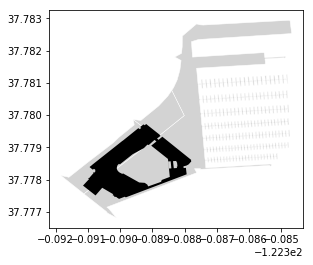

In [51]:
ax = (test_matches
     .query('sf16_BldgID == "201006.0000003"')
     .pipe(lambda df: df.assign(
         block_geometry=df.apply(lambda srs: blocks.iloc[int(srs['index_right'])].geometry, axis='columns'))
     )
     .set_geometry("block_geometry")
     .plot(linewidth=0.5, edgecolor='white', color='lightgray')
)

test_matches.query('sf16_BldgID == "201006.0000003"').head(1).plot(ax=ax, color='black')

Interesting. The unusual shape of the block likely corresponds with a marina. How does this multimatch property generalize to other blocks?

In [54]:
import numpy as np
np.random.seed(42)

test_matches = gpd.sjoin(buildings.sample(1000), blocks, how="left", op='intersects')

In [55]:
len(test_matches)

1010

Only about 1% of building footprints extend across multiple blocks. This may well be due to the changes between the city circa the building footprints dataset snapshot (~2016?), and the census blocks dataset snapshot (2010).

In [77]:
t = (test_matches
         .reset_index(drop=True)
         .groupby("sf16_BldgID")
         .filter(lambda df: True if len(df) > 1 else False))
t

,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry,index_right,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10
138,201006.0002722,2722,SF0855053,0.0000,0.0000,4227,1900,2671,771,2400.942749,251.930780,710,2596,1901,2546,4227,2580,4743,2163,4211.568015,236.375531,873,4250,2580,4272,4227,592,2797,2205,1810.624083,349.665964,1326,1703,592,1735,19.00,42.72,17.35,23.72,47.43,194.517865,1056.205564,(POLYGON Z ((-122.42334093485 37.7722385603071...,5863.0,06,G5040,None,Block 1016,+37.7724267,1016,0,S,4236,060750168021016,016802,-122.4235669,None,075
139,201006.0002722,2722,SF0855053,0.0000,0.0000,4227,1900,2671,771,2400.942749,251.930780,710,2596,1901,2546,4227,2580,4743,2163,4211.568015,236.375531,873,4250,2580,4272,4227,592,2797,2205,1810.624083,349.665964,1326,1703,592,1735,19.00,42.72,17.35,23.72,47.43,194.517865,1056.205564,(POLYGON Z ((-122.42334093485 37.7722385603071...,5094.0,06,G5040,None,Block 1015,+37.7727290,1015,0,S,7399,060750168021015,016802,-122.4229060,None,075
314,201006.0011134,11134,SF1939002,337.3702,348.6034,1386,10326,10504,178,10456.779221,36.697217,166,10477,10326,10471,1386,10476,10652,176,10523.922078,40.613847,159,10491,10476,10506,1386,0,278,278,67.150072,59.512102,215,6,77,51,103.26,105.06,0.51,1.80,106.52,66.752790,346.453658,(POLYGON Z ((-122.3657067450564 37.80968542785...,4819.0,06,G5040,None,Block 1060,+37.8105139,1060,0,S,23523,060750179021060,017902,-122.3641813,None,075
315,201006.0011134,11134,SF1939002,337.3702,348.6034,1386,10326,10504,178,10456.779221,36.697217,166,10477,10326,10471,1386,10476,10652,176,10523.922078,40.613847,159,10491,10476,10506,1386,0,278,278,67.150072,59.512102,215,6,77,51,103.26,105.06,0.51,1.80,106.52,66.752790,346.453658,(POLYGON Z ((-122.3657067450564 37.80968542785...,962.0,06,G5040,None,Block 1031,+37.8114200,1031,0,S,68827,060750179021031,017902,-122.3655140,None,075
330,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGON Z ((-122.3910005491485 37.75202643953...,4018.0,06,G5040,None,Block 1010,+37.7519755,1010,0,S,7622,060759809001010,980900,-122.3909277,None,075
331,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGON Z ((-122.3910005491485 37.75202643953...,3951.0,06,G5040,None,Block 1011,+37.7512455,1011,0,S,9582,060759809001011,980900,-122.3915803,None,075
332,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGON Z ((-122.3910005491485 37.75202643953...,577.0,06,G5040,None,Block 1014,+37.7520478,1014,0,S,8938,060759809001014,980900,-122.3920491,None,075
333,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGO

In [84]:
def overplot(test_matches, BldgID):
    ax = (test_matches
     .query(f'sf16_BldgID == "{BldgID}"')
     .pipe(lambda df: df.assign(
         block_geometry=df.apply(lambda srs: blocks.iloc[int(srs['index_right'])].geometry, axis='columns'))
     )
     .set_geometry("block_geometry")
     .plot(linewidth=0.5, edgecolor='white', color='lightgray')
    )

    test_matches.query(f'sf16_BldgID == "{BldgID}"').head(1).plot(ax=ax, color='black')

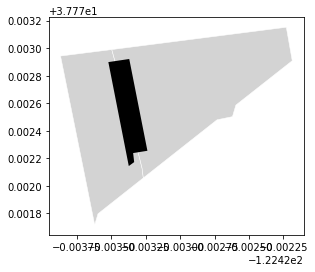

In [85]:
overplot(test_matches, "201006.0002722")

New construction has reshaped these census blocks. This is reflected in the newer building dataset, but not in the older census dataset. [Google Maps link](https://www.google.com/maps/place/37%C2%B046'20.1%22N+122%C2%B025'24.0%22W/@37.7725333,-122.4245846,333m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.7722386!4d-122.4233409).

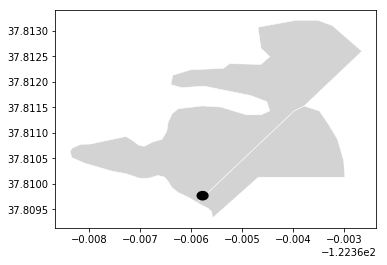

In [87]:
overplot(test_matches, "201006.0011134")

This is the reservoir section of Treasure Island. In fact this object is a water tower over the highway, which passes through a tunnel underneath it. [Google Maps link](https://www.google.com/maps/place/37%C2%B048'34.9%22N+122%C2%B021'56.5%22W/@37.8096894,-122.369951,1333m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.8096854!4d-122.3657067).

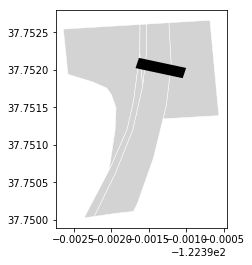

In [88]:
overplot(test_matches, "201006.0003336")

Building underneath an expressway. [Google Maps link](https://www.google.com/maps/place/37%C2%B045'07.3%22N+122%C2%B023'27.6%22W/@37.7520709,-122.3923265,339m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.7520264!4d-122.3910005).

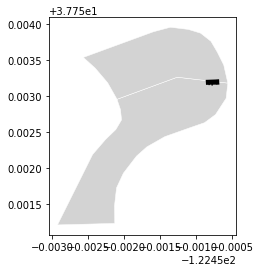

In [89]:
overplot(test_matches, "201006.0075312")

A small home in Forest Knolls. New construction perhaps, because the blocks do not reflect the surrounding geometry almost at all. Skipping the next couple...

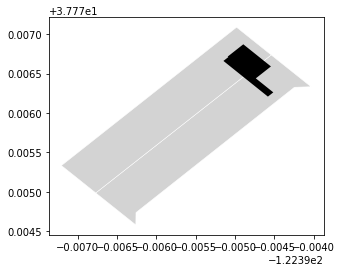

In [90]:
overplot(test_matches, "201006.0001573")

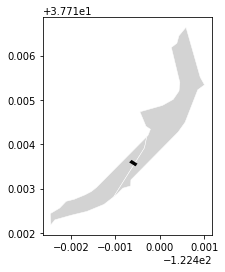

In [91]:
overplot(test_matches, "201006.0096127")

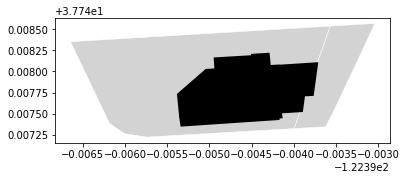

In [92]:
overplot(test_matches, "201006.0000055")

Industrial building with a slightly odd shape that is following a dirt road right beneath a highway. Looks like a census block definition inaccuracy to me. [Google Maps link](https://www.google.com/maps/place/37%C2%B044'50.8%22N+122%C2%B023'39.0%22W/@37.7478958,-122.3948882,342m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.7474419!4d-122.3941697).

The incidence rate of failures is low enough that we can remove the offending buildings, with the understanding that this loss of information will cause problems in newly reconstructed sections of the city (like the new medical campuses down in Dogpatch).

In [3]:
%time building_block_matches = gpd.sjoin(buildings, blocks, how="left", op='intersects')

CPU times: user 47.4 s, sys: 1.16 s, total: 48.6 s
Wall time: 47.6 s


In [98]:
len(building_block_matches) - len(buildings)

746

In [463]:
building_block_multimatches = building_block_matches.groupby("sf16_BldgID").filter(lambda df: len(df) > 1)

In [103]:
len(building_block_multimatches)

1444

(37.7, 37.85)

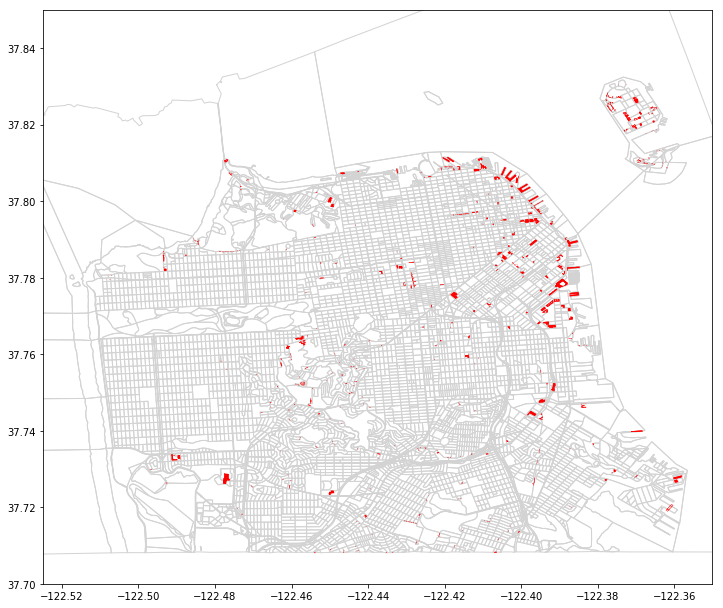

In [114]:
ax = blocks.plot(color='None', linewidth=1, edgecolor='lightgray', figsize=(12,12))
building_block_multimatches.plot(figsize=(12,12), color='red', ax=ax)
ax.set_xlim([-122.525, -122.35])
ax.set_ylim([37.7, 37.85])

There are small join inaccuracies all over the place, but overall the situation looks OK. In some areas you might be forced to define geometries by hand, though, like along the pier.

In [5]:
building_block_matches = building_block_matches.groupby("sf16_BldgID").filter(lambda df: len(df) == 1).reset_index()

There's also problems that go the other way. Some buildings don't get matched to *any* blocks.

In [464]:
building_block_misses = building_block_matches[pd.isnull(building_block_matches['index_right'])]

In [135]:
len(building_block_misses)

3141

(37.7, 37.85)

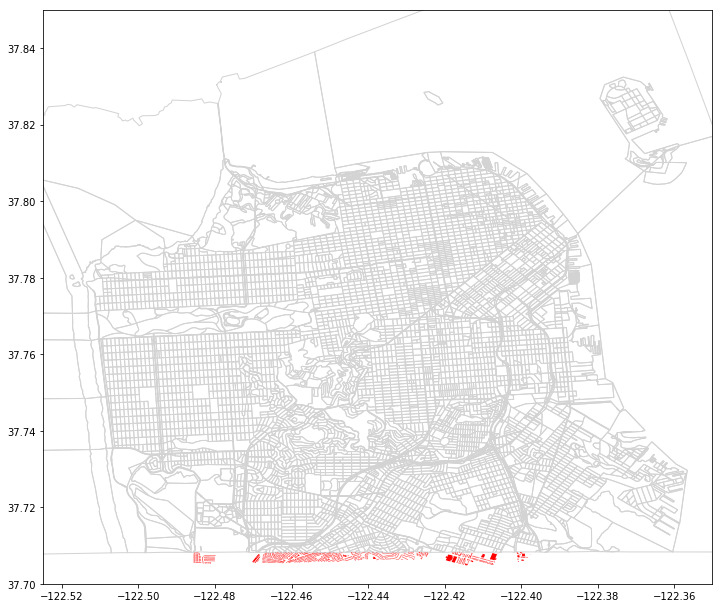

In [140]:
ax = blocks.plot(color='None', linewidth=1, edgecolor='lightgray', figsize=(12,12))
building_block_misses.plot(color='red', ax=ax)
ax.set_xlim([-122.525, -122.35])
ax.set_ylim([37.7, 37.85])

These are all due to the Census aligning the city of San Francisco differently from the city itself, which is interesting in of itself; city boundaries is usually the thing that federal and local sources agree on. Anyway we can drop these.

In [6]:
building_block_matches = building_block_matches[pd.notnull(building_block_matches['index_right'])]

### two, assigning blockfaces to blocks

This is "easy" when the block is a simple square.

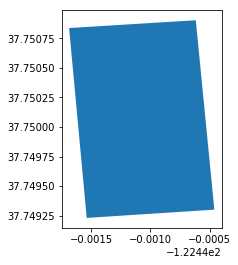

In [145]:
blocks.head(1).plot()

But what do you do when the blocks have complex shapes?

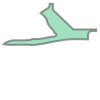

In [154]:
blocks.iloc[45].geometry

Simplifying geomtries shapes within specified tolerances is a difficult geometric problem. You want things like [line simplification algorithms](https://bost.ocks.org/mike/simplify/) to handle it.

In [164]:
blocks.geometry.map(lambda v: type(v)).value_counts()

<class 'shapely.geometry.multipolygon.MultiPolygon'>    7386
Name: geometry, dtype: int64

In [175]:
from shapely.geometry import mapping

In [199]:
len(mapping(blocks.iloc[45].geometry)['coordinates'][0][0])

52

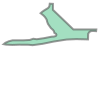

In [207]:
blocks.iloc[45].geometry.simplify(0.000001)

In [202]:
type(blocks.iloc[45].geometry.simplify(0.0002))

shapely.geometry.polygon.Polygon

In [193]:
len(mapping(blocks.iloc[45].geometry.simplify(0.0002))['coordinates'][0])

10

We can assign blockfaces on a simplified shape (which we determine based on a certain maximum mismatch tolerance), then translate those blockfaces to the equivalent segments on the "true" polygons, as the `simplify` routine does not modify points: it only removes them.

In [217]:
blocks.iloc[45].geometry.difference(blocks.iloc[45].geometry.simplify(0.001)).area / blocks.iloc[45].geometry.area

0.5657524905975444

In [218]:
blocks.iloc[45].geometry.difference(blocks.iloc[45].geometry.simplify(0.0001)).area / blocks.iloc[45].geometry.area

0.017031721653597644

In [28]:
def simplify(shp, tol=0.05):
    """
    Generate a simplified shape for shp, within a 5 percent tolerance.
    
    Used for blockface alignment.
    """
    for thresh in [0.001, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001]:
        simp = shp.simplify(thresh)
        if shp.difference(simp).area / shp.area < tol:
            break
    
    return simp

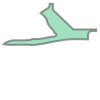

In [258]:
blocks.iloc[45].geometry

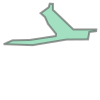

In [259]:
simplify(blocks.iloc[45].geometry)

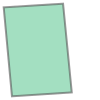

In [260]:
blocks.iloc[0].geometry

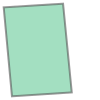

In [261]:
simplify(blocks.iloc[0].geometry)

There is a handful of blocks that our algorithm fails on.

In [284]:
from tqdm import tqdm_notebook
bad_blocks = []

for idx, geom in tqdm_notebook(zip(blocks.geometry.index, blocks.geometry.values)):
    try:
        simplify(geom)
    except Exception:
        bad_blocks.append((idx, geom))

TopologyException: Input geom 0 is invalid: Self-intersection at or near point -122.45601400000001 37.752358999999998 at -122.45601400000001 37.752358999999998
TopologyException: Input geom 0 is invalid: Self-intersection at or near point -122.37997 37.760224000000001 at -122.37997 37.760224000000001
TopologyException: Input geom 0 is invalid: Self-intersection at or near point -122.47349299999999 37.798060000000007 at -122.47349299999999 37.798060000000007
TopologyException: Input geom 0 is invalid: Self-intersection at or near point -122.42515399999999 37.732839999999996 at -122.42515399999999 37.732839999999996


In [287]:
bad_blocks

[(345, <shapely.geometry.multipolygon.MultiPolygon at 0x13a59ebe0>),
 (3987, <shapely.geometry.multipolygon.MultiPolygon at 0x1418da8d0>),
 (5308, <shapely.geometry.multipolygon.MultiPolygon at 0x14697d358>),
 (5554, <shapely.geometry.multipolygon.MultiPolygon at 0x1477ce048>)]

These blocks are all invalid geometric shapes to begin with. They have self-intersections.

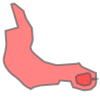

In [283]:
blocks.iloc[345].geometry

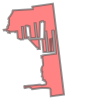

In [288]:
blocks.iloc[3987].geometry

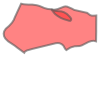

In [289]:
blocks.iloc[5308].geometry

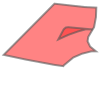

In [290]:
blocks.iloc[5554].geometry

What do these correspond with in terms of physical features?

In [293]:
import mplleaflet

gpd.GeoSeries(blocks.iloc[5308].geometry).plot()
mplleaflet.show()

In [294]:
gpd.GeoSeries(blocks.iloc[5554].geometry).plot()
mplleaflet.show()

In [295]:
gpd.GeoSeries(blocks.iloc[345].geometry).plot()
mplleaflet.show()

In [296]:
gpd.GeoSeries(blocks.iloc[3987].geometry).plot()
mplleaflet.show()

Three are cul-de-sacs featuring circular roads around certral greens linked to the rest of the road network by a single input/output channel. It appears that this is how the Census decided to tackle this particular type of geometry. Luckily these are extremely rare in cities.

The last one is just a geometry error.

The easy solution to these geometry problems is to use a zero-buffer, removing these streets from consideration. The true solution would probably be to manually or semi-automatically partition the block into new blocks, using the edge of the looped segment as the partition edge.

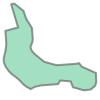

In [291]:
blocks.iloc[345].geometry.buffer(0)

In [298]:
simp_blocks = blocks.geometry.map(lambda v: simplify(v.buffer(0)))

In [305]:
simp_block_coord_lens = simp_blocks.map(lambda g: len(mapping(g)['coordinates'][0]))

In [309]:
simp_block_coord_lens.value_counts().sort_index()

1         4
4       113
5      5251
6      1058
7       351
8       222
9       100
10       79
11       44
12       33
13       24
14       14
15       14
16        4
17       10
18        5
19        5
20        5
21        8
22        5
23        6
24        2
25        1
26        1
27        1
29        1
30        2
31        1
32        3
33        3
34        1
35        1
37        1
38        1
42        1
47        1
52        1
54        1
55        1
62        1
70        1
86        1
173       1
215       1
225       1
387       1
Name: geometry, dtype: int64

934


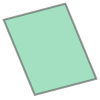

In [321]:
s = simp_blocks[simp_block_coord_lens == 5].sample(1)
print(s.index.values[0])
s.iloc[0]

5 is the most common number of coordinates because it corresponds with the most common type of block, the rectangular block (as well as any other block geometry which happens to have four sides, like an inflected triangle). It's 5, not 4, because the start/end point appears the coordinate sequence twice, once at the beginning and once at the end.

In [325]:
mapping(simp_blocks.iloc[934])['coordinates']

(((-122.41298499999999, 37.729172999999996),
  (-122.41248999999999, 37.727972),
  (-122.41347500000002, 37.727714999999996),
  (-122.41397099999999, 37.728915),
  (-122.41298499999999, 37.729172999999996)),)

In [329]:
def sample_n_sides(n):
    s = simp_blocks[simp_block_coord_lens == n].sample(1)
    print(s.index.values[0])
    return s.iloc[0]

3507


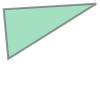

In [333]:
sample_n_sides(4)

4 is triangles. There is no 2 or 3 because you can't have single-point or two-point polygons. But there is a 1, which is for multipolygons which cannot be simplfiied down to polygons by the `simplify` process. These blocks all correspond with island groupings, and don't simplify because unlike ground polygons they are not contiguous, as the islands are not linked to one another:

1575


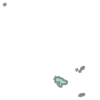

In [335]:
sample_n_sides(1)

We can freely omit these blocks (though we should do that earlier in the pipeline).

How about the long tail of more complicated stuff...

In [347]:
gpd.GeoSeries(sample_n_sides(17)).plot()
mplleaflet.show()

7330


16-gons are all good approximations of complex blocks (a part of the USF campus is one).

In [348]:
gpd.GeoSeries(sample_n_sides(387)).plot()
mplleaflet.show()

6990


As expected, 387 is a faithful-ish reconstruction of a marina.

In [349]:
gpd.GeoSeries(sample_n_sides(86)).plot()
mplleaflet.show()

7061


86 is the negative implement of that marina on the water. It's not really a block, given that it's completely over water.

In [350]:
gpd.GeoSeries(sample_n_sides(42)).plot()
mplleaflet.show()

6501


42 is the negative of the Farallon Islands MPA. Again completely water.

...overall the cuts look fine. Now let's partition the blocks into `{simplfied, original}` blockfaces.

In [29]:
def blockfaces_for_block(block):
    """Generate a GeoDataFrame of block faces from a block definition."""
    orig = block.geometry.buffer(0)  # MultiPolygon -> Polygon
    simp = simplify(orig)
    
    orig_coords = mapping(orig)['coordinates'][0]
    simp_coords = mapping(simp)['coordinates'][0]

    simp_out = []
    orig_out = []

    orig_coords_idx = 0

    # generate coordinate strides
    for idx in range(1, len(simp_coords)):
        simp_blockface_start_coord, simp_blockface_end_coord = simp_coords[idx - 1], simp_coords[idx]

        orig_blockface_start_coord_idx = orig_coords_idx
        orig_coords_idx += 1
        while orig_coords[orig_coords_idx] != simp_blockface_end_coord:
            orig_coords_idx += 1
        orig_blockface_end_coord_idx = orig_coords_idx + 1

        simp_out.append((simp_blockface_start_coord, simp_blockface_end_coord))
        orig_out.append(orig_coords[orig_blockface_start_coord_idx:orig_blockface_end_coord_idx])

    # id will be a mutation of the block id
    block_id = block.geoid10

    out = []
    from shapely.geometry import LineString

    # frame id, block id, original geometry, and simplified geometry
    for n, (simp_blockface_coord_seq, orig_blockface_coord_seq) in enumerate(zip(simp_out, orig_out)):
        blockface_num = n + 1
        out.append({
            "geoid10_n": f"{block_id}_{blockface_num}",
            "geoid10": block_id,
            "simplified_geometry": LineString(simp_blockface_coord_seq),
            "geometry": LineString(orig_blockface_coord_seq)
        })

    out = gpd.GeoDataFrame(out)
    
    return out

Results for a simple geom and a complex geom:

In [401]:
blockfaces_for_block(blocks.iloc[0])

,geoid10,geoid10_n,geometry,simplified_geometry
0,060750257013008,060750257013008_1,"LINESTRING (-122.440616 37.750902, -122.440459...","LINESTRING (-122.440616 37.750902, -122.440459..."
1,060750257013008,060750257013008_2,"LINESTRING (-122.440459 37.749301, -122.441538...","LINESTRING (-122.440459 37.749301, -122.441538..."
2,060750257013008,060750257013008_3,"LINESTRING (-122.441538 37.74923100000001, -12...","LINESTRING (-122.441538 37.74923100000001, -12..."
3,060750257013008,060750257013008_4,"LINESTRING (-122.441687 37.75083600000001, -12...","LINESTRING (-122.441687 37.75083600000001, -12..."


In [402]:
blockfaces_for_block(blocks.iloc[7061]).head()

,geoid10,geoid10_n,geometry,simplified_geometry
0,060750257013008,060750257013008_1,"LINESTRING (-122.419942 37.809021, -122.419948...","LINESTRING (-122.419942 37.809021, -122.417886..."
1,060750257013008,060750257013008_2,"LINESTRING (-122.417886 37.808615, -122.418966...","LINESTRING (-122.417886 37.808615, -122.42002 ..."
2,060750257013008,060750257013008_3,"LINESTRING (-122.42002 37.808841, -122.420805 ...","LINESTRING (-122.42002 37.808841, -122.421076 ..."
3,060750257013008,060750257013008_4,"LINESTRING (-122.421076 37.812889, -122.420182...","LINESTRING (-122.421076 37.812889, -122.407482..."
4,060750257013008,060750257013008_5,"LINESTRING (-122.407482 37.812728, -122.405782...","LINESTRING (-122.407482 37.812728, -122.398482..."


We can see how segments get simplified in the simplified geometry:

In [405]:
(blockfaces_for_block(blocks.iloc[7061]).geometry == blockfaces_for_block(blocks.iloc[7061]).simplified_geometry)\
    .value_counts()

False    67
True     18
dtype: int64

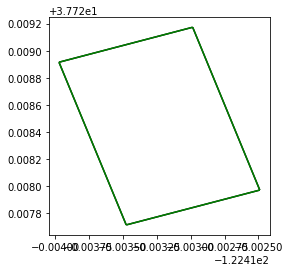

In [393]:
ax = out.plot(color='black')
out.set_geometry('simplified_geometry').plot(ax=ax, color='green')

In [30]:
from shapely.geometry import Polygon

def drop_noncontiguous_blocks(blocks):
    return blocks[blocks.geometry.map(lambda g: isinstance(g.buffer(0), Polygon))]

In [31]:
len(blocks), len(drop_noncontiguous_blocks(blocks))

(7386, 7382)

In [37]:
contiguous_blocks = blocks[blocks.geometry.map(lambda g: isinstance(g.buffer(0), Polygon))]

In [424]:
# blocks = drop_noncontiguous_blocks(blocks)

In [42]:
# len(blocks)

In [43]:
from shapely.geometry import mapping

In [41]:
%time blockfaces = pd.concat(blocks.apply(lambda b: blockfaces_for_block(b), axis='columns').values)

CPU times: user 29.2 s, sys: 364 ms, total: 29.5 s
Wall time: 29.9 s


### three, assigning buildings to blockfaces

Buildings have an N-to-N to relationship with blockfaces. Each building may have multiple `frontage` assignments (0-to-N), each of which is a chunk of a `blockface` (N-to-1). A blockface may have pieces not assigned to any building, if it is fronted by e.g. a park, or by the water, or a highway, or any of a number of other things.

In [44]:
# This code ripped out of geoplot

def _build_voronoi_polygons(df):
    """
    Given a GeoDataFrame of point geometries and pre-computed plot extrema, build Voronoi simplexes for the given
    points in the given space and returns them.
    Voronoi simplexes which are located on the edges of the graph may extend into infinity in some direction. In
    other words, the set of points nearest the given point does not necessarily have to be a closed polygon. We force
    these non-hermetic spaces into polygons using a subroutine.
    Parameters
    ----------
    df : GeoDataFrame instance
        The `GeoDataFrame` of points being partitioned.
    Returns
    -------
    polygons : list of shapely.geometry.Polygon objects
        The Voronoi polygon output.
    """
    from scipy.spatial import Voronoi
    geom = np.array(df.geometry.map(lambda p: [p.x, p.y]).tolist())
    vor = Voronoi(geom)

    polygons = []

    for idx_point, point in enumerate(vor.points):
        idx_point_region = vor.point_region[idx_point]
        idxs_vertices = np.array(vor.regions[idx_point_region])

        is_finite = True if not np.any(idxs_vertices == -1) else False

        if is_finite:
            # Easy case, the region is closed. Make a polygon out of the Voronoi ridge points.
            idx_point_region = vor.point_region[idx_point]
            idxs_vertices = np.array(vor.regions[idx_point_region])
            region_vertices = vor.vertices[idxs_vertices]
            region_poly = shapely.geometry.Polygon(region_vertices)

            polygons.append(region_poly)

        else:
            # Hard case, the region is open. Project new edges out to the margins of the plot.
            # See `scipy.spatial.voronoi_plot_2d` for the source of this calculation.
            point_idx_ridges_idx = np.where((vor.ridge_points == idx_point).any(axis=1))[0]
            ptp_bound = vor.points.ptp(axis=0)
            center = vor.points.mean(axis=0)

            finite_segments = []
            infinite_segments = []

            pointwise_ridge_points = vor.ridge_points[point_idx_ridges_idx]
            pointwise_ridge_vertices = np.asarray(vor.ridge_vertices)[point_idx_ridges_idx]

            for pointidx, simplex in zip(pointwise_ridge_points, pointwise_ridge_vertices):
                simplex = np.asarray(simplex)

                if np.all(simplex >= 0):
                    finite_segments.append(vor.vertices[simplex])

                else:
                    i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

                    t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                    t /= np.linalg.norm(t)
                    n = np.array([-t[1], t[0]])  # normal

                    midpoint = vor.points[pointidx].mean(axis=0)
                    direction = np.sign(np.dot(midpoint - center, n)) * n
                    far_point = vor.vertices[i] + direction * ptp_bound.max()

                    infinite_segments.append([vor.vertices[i], far_point])
                    
            if len(finite_segments) == 0:
                ls = np.vstack([np.asarray(infinite_segments)])
            else:
                ls = np.vstack([np.asarray(infinite_segments), np.asarray(finite_segments)])

            # We have to trivially sort the line segments into polygonal order. The algorithm that follows is
            # inefficient, being O(n^2), but "good enough" for this use-case.
            ls_sorted = []

            while len(ls_sorted) < len(ls):
                l1 = ls[0] if len(ls_sorted) == 0 else ls_sorted[-1]
                l1 = l1.tolist() if not isinstance(l1, list) else l1
                matches = []

                for l2 in [l for l in ls if l.tolist() != l1]:
                    if np.any(l1 == l2):
                        matches.append(l2)
                    elif np.any(l1 == l2[::-1]):
                        l2 = l2[::-1]
                        matches.append(l2)

                if len(ls_sorted) == 0:
                    ls_sorted.append(l1)

                ls_sorted.append([m.tolist() for m in matches if m.tolist() not in ls_sorted][0])

            # Build and return the final polygon.
            polyline = np.vstack(ls_sorted)
            geom = shapely.geometry.Polygon(polyline).convex_hull
            polygons.append(geom)

    return polygons

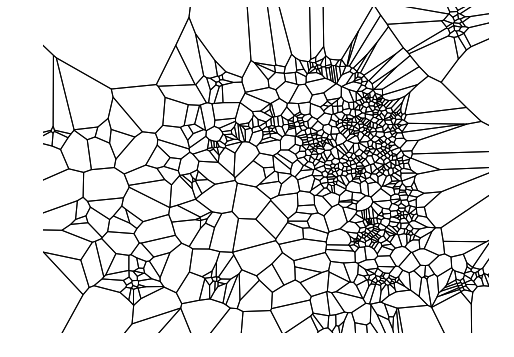

In [443]:
import geoplot as gplt
gplt.voronoi(gpd.GeoDataFrame(geometry=buildings.head(1000).geometry.centroid))

In [456]:
import shapely
example_polys = _build_voronoi_polygons(gpd.GeoDataFrame(geometry=buildings.head(4).geometry.centroid))

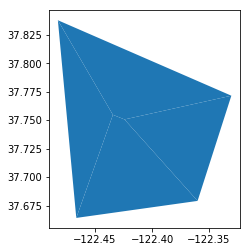

In [461]:
gpd.GeoDataFrame(geometry=example_polys).plot()

In [47]:
def block_buildings(block_index):
    bldgs = building_block_matches[building_block_matches['index_right'] == block_index]
    return bldgs

def block_clipped_voronoi(block_index):
    bldgs = block_buildings(block_index)
    polys = _build_voronoi_polygons(bldgs.geometry.centroid)
    return gpd.GeoDataFrame(geometry=polys)

(37.736, 37.745)

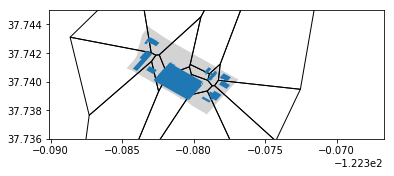

In [93]:
import numpy as np
import shapely

ax = gpd.GeoDataFrame([contiguous_blocks.loc[6307]], geometry=[contiguous_blocks.loc[6307].geometry])\
        .plot(color='lightgray')
block_clipped_voronoi(6307.0).plot(color='None', linewidth=1, edgecolor='black', ax=ax)
block_buildings(6307.0).plot(ax=ax)

ax.set_ylim([37.736, 37.745])

This sort-of works, but doesn't do a great job. It also fails outright if there are exactly two buildings to a block (though this can be worked around).

...after some thought, this is a difficult problem in computational geometry.

A good approximation approach would be to calculate polygon to point distances for all of the points on the blockface, using a search strategy that allows us to garuantee inaccuracies fall within a certain $\epsilon$.

I suggest assigning buildings to frontages manually, and I could do with investigating an iterative approximation solution down the line.

In [88]:
np.random.randint(len(contiguous_blocks))

4022

In [99]:
def plot_voronoi_breakdown(block_index):
    ax = gpd.GeoDataFrame([contiguous_blocks.loc[block_index]], 
                          geometry=[contiguous_blocks.loc[block_index].geometry])\
            .plot(color='lightgray')
    # import pdb; pdb.set_trace()
    # block_clipped_voronoi(block_index).plot(color='None', linewidth=1, edgecolor='black', ax=ax)
    block_buildings(block_index).plot(ax=ax)
    return ax

In [69]:
# import numpy as np
# import shapely

# ax = gpd.GeoDataFrame([contiguous_blocks.loc[1349]], geometry=[contiguous_blocks.loc[1349].geometry])\
#         .plot(color='lightgray')
# block_clipped_voronoi(1349.0).plot(color='None', linewidth=1, edgecolor='black', ax=ax)
# block_buildings(1349.0).plot(ax=ax)

In [67]:
building_block_matches[building_block_matches['index_right'] == 1349]

,index,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry,index_right,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10
3,5,201006.0000006,6,SF3551001,21.7563,53.5712,99724,575,718,143,675.857066,23.543243,143,685,575,683,99724,705,2507,1802,1977.987195,186.48843,1522,2123,705,1987,99724,14,1895,1881,1302.132054,185.491950,1529,1436,14,1310,5.75,19.87,13.10,14.12,25.07,626.100650,24929.509671,(POLYGON Z ((-122.4135650581929 37.76583242604...,1349.0,06,G5040,None,Block 2040,+37.7661923,2040,0,S,35142,060750177002040,017700,-122.4142837,None,075
1597,1713,201006.0001714,1714,SF3551003,21.7563,53.5712,6131,684,747,63,716.311532,10.650763,64,705,684,714,6131,767,1844,1077,1474.448051,144.54577,687,1645,767,1497,6131,38,1156,1118,758.126407,143.415536,678,918,38,785,6.84,14.97,7.85,8.13,18.44,176.875104,1532.239392,(POLYGON Z ((-122.4138918273129 37.76550651637...,1349.0,06,G5040,None,Block 2040,+37.7661923,2040,0,S,35142,060750177002040,017700,-122.4142837,None,075


### four, assigning blockfaces to street segments

In [72]:
streets.head(1)

,zip_code,f_node_cnn,classcode,accepted,jurisdicti,street_gc,cnn,layer,nhood,st_type,streetname,rt_fadd,cnntext,lf_fadd,t_node_cnn,multigeom,street,district,lf_toadd,oneway,rt_toadd,geometry
0,94114,26132000,0,N,None,CROWN,15145000.0,PRIVATE,Twin Peaks,CT,CROWN CT,0.0,15145000,0.0,54223000,false,CROWN,None,0.0,B,0.0,LINESTRING (-122.4469424451799 37.757228921523...


In [73]:
blockfaces.head(1)

,geoid10,geoid10_n,geometry,simplified_geometry
0,060750213002002,060750213002002_1,"LINESTRING (-122.440616 37.750902, -122.440459...","LINESTRING (-122.440616 37.750902, -122.440459..."


In [102]:
import rtree
index = rtree.index.Index()

In [139]:
import rtree
index = rtree.index.Index()

for idx, street in streets.iterrows():
    x, y = street.geometry.envelope.exterior.coords.xy
    index.insert(idx, (min(x), min(y), max(x), max(y)))

In [166]:
def n_nearest_streets(block, mult=2):
    """
    Returns a frame of streets nearest the given block. mult controls how many times more
    streets will be looked up than the block has sides; because we need to return a lot of
    results, just to make sure we get every street fronting the block.
    """
    x, y = block.geometry.envelope.exterior.coords.xy
    n = (len(x) - 1) * 2
    idxs = index.nearest((min(x), min(y), max(x), max(y)), n)
    return streets.iloc[list(idxs)]

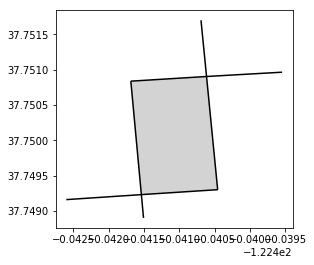

In [167]:
ax = blocks.iloc[:1].plot(color='lightgray')
n_nearest_streets(blocks.iloc[0]).plot(ax=ax, color='black')

-122.45082565287994 37.741554061250724 -122.43374388214252 37.75531673033618


(37.741554061250724, 37.75531673033618)

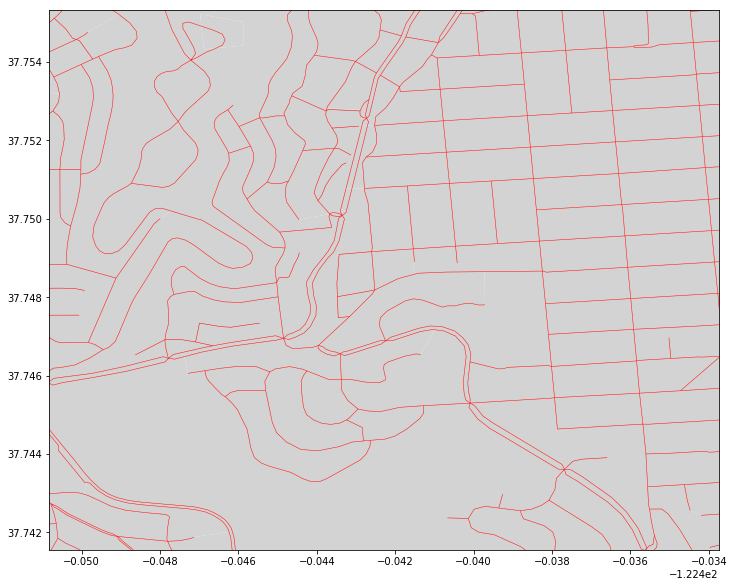

In [202]:
ax = streets.plot(color='red', linewidth=0.5, figsize=(12,12))
x_ext, y_ext = ax.get_xlim(), ax.get_ylim()

contiguous_blocks.plot(ax=ax, color='lightgray')

x_start_rand = x_ext[0] + np.random.random() * 0.9 * (x_ext[1] - x_ext[0])
y_start_rand = y_ext[0] + np.random.random() * 0.9 * (y_ext[1] - y_ext[0])
x_end_rand = x_start_rand + 0.1 * (x_ext[1] - x_ext[0])
y_end_rand = y_start_rand + 0.1 * (y_ext[1] - y_ext[0])

print(x_start_rand, y_start_rand, x_end_rand, y_end_rand)

ax.set_xlim([x_start_rand, x_end_rand])
ax.set_ylim([y_start_rand, y_end_rand])

If you leaf through the random snapshots of blocks and streets comapped above, you will see that streets and blocks are a very close, but imperfect, match for one another. Which is good.

In [209]:
test_blockface = blockfaces.iloc[:1]
streets_matched = n_nearest_streets(test_blockface.iloc[0])

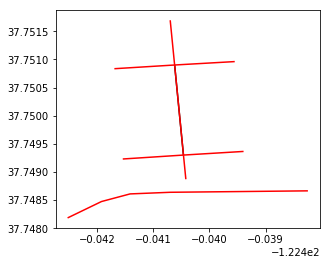

In [214]:
ax = test_blockface.plot(color='black')
streets_matched.plot(ax=ax, color='red')

In [335]:
def naively_find_matching_street(blockface):
    streets_matched = n_nearest_streets(blockface)
    sub_matches = []
    for idx, street in streets_matched.iterrows():
        if street.geometry.buffer(0.00005).contains(blockface.geometry):
            return gpd.GeoDataFrame([street], geometry=[street.geometry])
        elif blockface.geometry.buffer(0.00005).contains(street.geometry):
            sub_matches.append(street)
    
    if len(sub_matches) > 0:
        return gpd.GeoDataFrame(sub_matches)

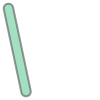

In [283]:
streets.sample(1).iloc[0].geometry.buffer(0.00005)

In [336]:
from tqdm import tqdm_notebook
matches = []

sample = blockfaces.sample(1000)
for idx, blockface in tqdm_notebook(sample.iterrows()):
    matches.append(naively_find_matching_street(blockface))

In [337]:
sum([match is None for match in matches]) / len(matches)

0.138

This algorithm is surpisingly bad. I take a pass at refining it. First of all, notice ths pattern:

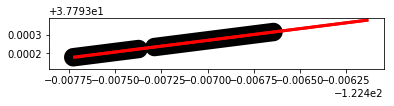

In [330]:
sample_blockface = sample.iloc[sample_idx]
ax = gpd.GeoSeries(sample_blockface).plot(color='red', linewidth=3)
n_nearest_streets(sample_blockface).buffer(0.00005).iloc[7:8].plot(color='black', ax=ax)
n_nearest_streets(sample_blockface).buffer(0.00005).iloc[9:10].plot(color='black', ax=ax)

Ah, so the street network may be (and often is) more granular than the blockface because it includes small private streets which are excluded from census block consideration.

I added a routine for dealing with this, which reduced the error rate by 50% (and brought overall accuracy to ~85%).

But there are still total misses in the dataset.

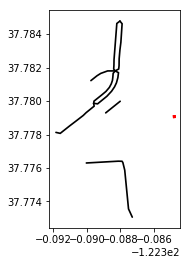

In [342]:
sample_blockface = sample.iloc[415]
ax = gpd.GeoSeries(sample_blockface).plot(color='red', linewidth=3)
n_nearest_streets(sample_blockface).buffer(0.00005).plot(color='black', ax=ax)

In [348]:
sample_blockface = sample.iloc[415]
ax = gpd.GeoSeries(sample_blockface).plot(color='red')
n_nearest_streets(sample_blockface).buffer(0.00005).plot(color='black', ax=ax)

import mplleaflet
mplleaflet.show()

This is a segment of the pier. We'd be totally safe dropping it.

In [364]:
sample_idx = np.random.choice(np.where([match is None for match in matches])[0])
print(sample_idx)
sample_blockface = sample.iloc[sample_idx]
ax = gpd.GeoSeries(sample_blockface).plot(color='red')
n_nearest_streets(sample_blockface).plot(color='black', ax=ax)

import mplleaflet
mplleaflet.show()

720


After looking through dozens of examples using the above, I think we'd actually be safe dropping most of the matches, as they correspond to segments that aren't facing streets (the N-to-0 cases), or otherwise to complex blockfront segments that are OK to leave to hand matching and correction.

In [420]:
from tqdm import tqdm_notebook
matches = []

for idx, blockface in tqdm_notebook(blockfaces.iterrows()):
    matches.append(naively_find_matching_street(blockface))

In [379]:
unmatched_blockfaces = blockfaces.iloc[np.where([m is None for m in matches])[0]]

(37.72, 37.82)

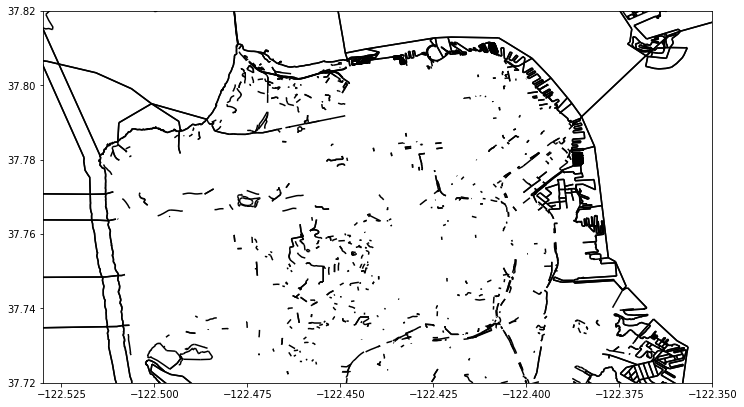

In [387]:
ax = unmatched_blockfaces.plot(color='black', figsize=(12,12))
ax.set_xlim([-122.53, -122.35])
ax.set_ylim([37.72, 37.82])

This is a plot of blockfaces which did not get matched to streets. We can see:
* Blockfaces corresponding with swatches of the ocean, defined by blocks which extend into the sea (a census block definition peculiarity.
* Blockfaces bounded by water, e.g. piers and blocks facing the water with no roadway.
* Blockfaces on elevated segments of major arterial roads, e.g. highways.
* Blockfaces that do not exist (due to changes in the geometry of the city).
* Blockfaces which are not accurately potrayed in one or another dataset (e.g. inaccuracies in the definitions, occassionally in rectified areas but especially in non-grid areas).

Depending on the target, you may need to do some manual repair work. But this looks to be about as good as we can get it with automated tools.

In [390]:
ax = unmatched_blockfaces.plot(color='black', figsize=(12,12))
mplleaflet.show()

### six, assigning street segments to blocks

To review, we have:
* Matched blocks to blockfaces (1-to-N).
* Matched streets to blockfaces (N-to-N).
* Punted on matching buildings to blockfaces.

Now we need to match blocks to street segments:

* Street segments are pieces of street adjacent to the block.
* In simple cases street segments may correspond with entire blockfaces, but in more complex cases this will not be true.
* Every block has 1-to-N relationship to street segments.
* The spatial relationship of the street segments is defined by their clockwise wind round the block (with respect to the first coordinate in the block polygon).
* A blockface may relate with zero street segments, in cases where the blockface is facing the sea, or a wall propped against a highway, or an errant non-match in the data (as shown above).

In [429]:
pd.Series([len(m) if m is not None else 0 for m in matches]).value_counts()

1     29008
0      4877
2      1876
3       287
4        89
5        22
6        10
7         6
8         3
12        2
11        1
10        1
dtype: int64

In [450]:
matches_merge = []

for idx, (_, dat) in tqdm_notebook(enumerate(blockfaces.iterrows())):
    corresponding_street_segments = matches[idx]
    geoid10 = np.nan if corresponding_street_segments is None else dat.geoid10
    
    if pd.notnull(geoid10):
        corresponding_street_segments = corresponding_street_segments.assign(
            geoid10=geoid10, geoid10_n=dat.geoid10_n
        )
        
    matches_merge.append(corresponding_street_segments)
    
street_segments = pd.concat(matches_merge)
del matches_merge

In [451]:
street_segments.head()

,zip_code,f_node_cnn,classcode,accepted,jurisdicti,street_gc,cnn,layer,nhood,st_type,streetname,rt_fadd,cnntext,lf_fadd,t_node_cnn,multigeom,street,district,lf_toadd,oneway,rt_toadd,geometry,geoid10,geoid10_n
9154,94114,26083000,5,Y,DPW,HOFFMAN,6941000.0,STREETS,Noe Valley,AVE,HOFFMAN AVE,400.0,6941000,401.0,26082000,false,HOFFMAN,None,499.0,B,498.0,LINESTRING (-122.4406160045902 37.750902098083...,060750213002002,060750213002002_1
14989,94114,26082000,5,Y,DPW,25TH,1459000.0,STREETS,Noe Valley,ST,25TH ST,4600.0,1459000,4601.0,22322000,false,25TH,None,4699.0,B,4698.0,LINESTRING (-122.4404585878594 37.749300756873...,060750213002002,060750213002002_2
10437,94114,26086000,5,Y,DPW,FOUNTAIN,5739000.0,STREETS,Noe Valley,ST,FOUNTAIN ST,2.0,5739000,1.0,22322000,false,FOUNTAIN,None,99.0,B,98.0,LINESTRING (-122.441687212498 37.7508360809474...,060750213002002,060750213002002_3
15078,94114,26083000,5,Y,DPW,24TH,1367000.0,STREETS,Noe Valley,ST,24TH ST,4400.0,1367000,4401.0,26086000,false,24TH,None,4449.0,B,4446.0,LINESTRING (-122.4406160045902 37.750902098083...,060750213002002,060750213002002_4
11300,94114,25764000,5,Y,DPW,DOUGLASS,4956000.0,STREETS,Noe Valley,ST,DOUGLASS ST,820.0,4956000,851.0,25763000,false,DOUGLASS,None,899.0,B,898.0,LINESTRING (-122.438396848299 37.7502263555848...,060750213002000,060750213002000_1


* Match to `blocks` on `geoid10`.
* Match to `blockfaces` on `geoid10_n`.

In [461]:
blocks.set_index('geoid10').join(street_segments.set_index('geoid10'), how='left', lsuffix='_l', rsuffix='_r')\
    .reset_index().groupby('geoid10').apply(lambda df: len(df)).value_counts().sort_index()

1      224
2      149
3      457
4     3944
5     1258
6      598
7      299
8      156
9       97
10      61
11      34
12      28
13      17
14      15
15      13
16       8
17      11
18       5
19       1
20       1
21       3
22       1
23       1
26       2
27       1
29       1
59       1
dtype: int64

Most blocks have a few corresponding street segments, but some have a lot (as per the expectation).

### save

We've busted open a lot of ground in this notebook, but we're running out of room. Let's save the products to file and proceed from there.

In [471]:
!mkdir ../data/processed

In [480]:
building_block_matches.rename(columns={'index_right': 'index_block'})\
    .to_csv("../data/processed/buildings.csv")

In [481]:
blockfaces.to_csv("../data/processed/blockfaces.csv")

In [482]:
street_segments.to_csv("../data/processed/street_segments.csv")